<a href="https://colab.research.google.com/github/jeon-maker/Team4_food-project/blob/main/use_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [ ]:
META_FILE = '/content/drive/MyDrive/crowd_detection/labels.csv'


In [ ]:
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'


In [ ]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'/content/drive/MyDrive/crowd_detection/frames/frames/seq_{image_id}.jpg'

def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)

def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()

def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size
    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image

def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [ ]:
set_display()


In [ ]:
# Input data
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,/content/drive/MyDrive/crowd_detection/frames/...
1,2,41,/content/drive/MyDrive/crowd_detection/frames/...
2,3,41,/content/drive/MyDrive/crowd_detection/frames/...
3,4,44,/content/drive/MyDrive/crowd_detection/frames/...
4,5,41,/content/drive/MyDrive/crowd_detection/frames/...


In [ ]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


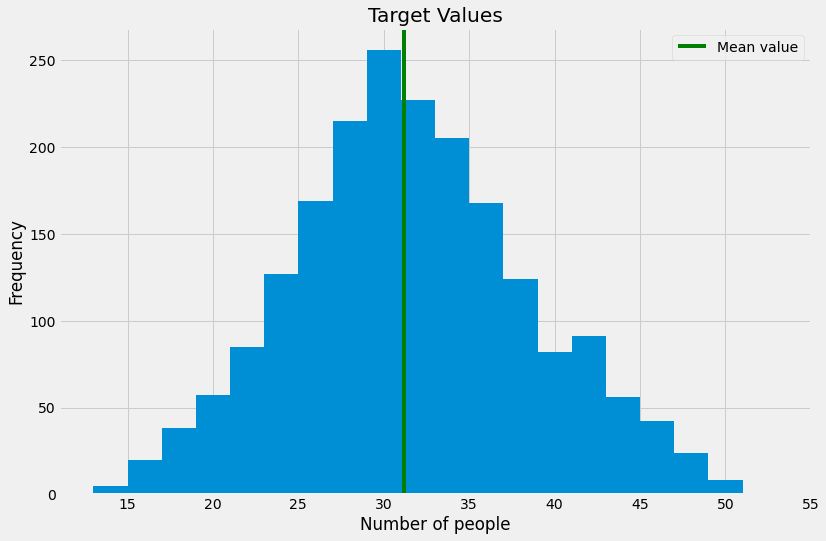

In [ ]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [ ]:
detector = hub.load(MODEL_PATH)


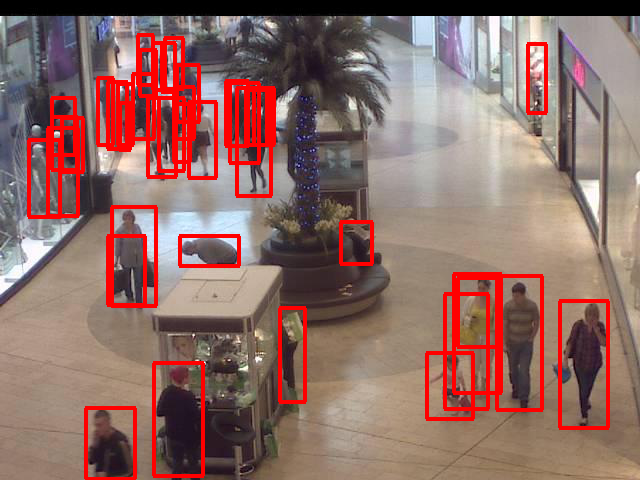

In [ ]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '/content/drive/MyDrive/crowd_detection/frames/frames/seq_000010.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)

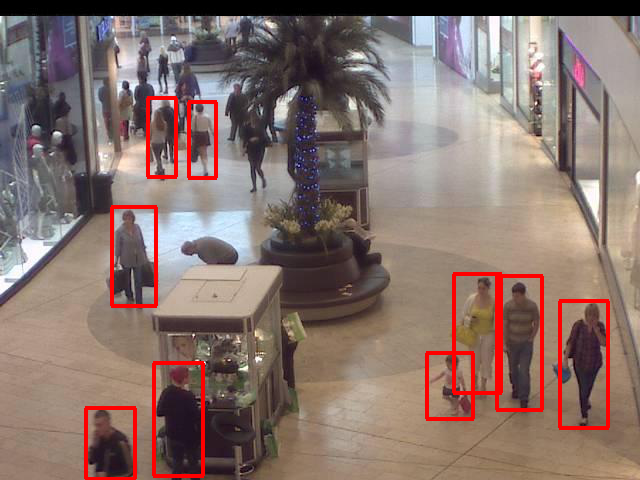

In [ ]:
draw_bboxes(example_path, results, threshold=0.5)


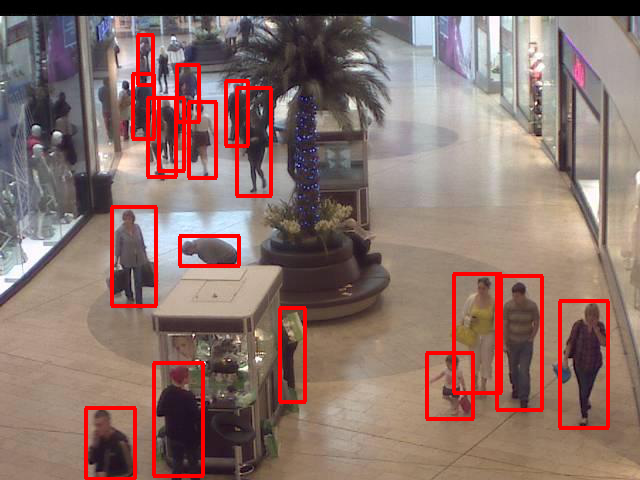

In [ ]:
draw_bboxes(example_path, results, threshold=0.25)


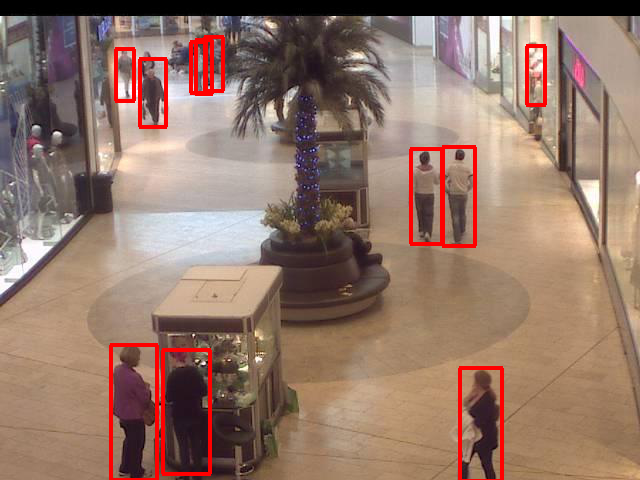

In [ ]:
example_path = data.loc[data['count'] == data['count'].min(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

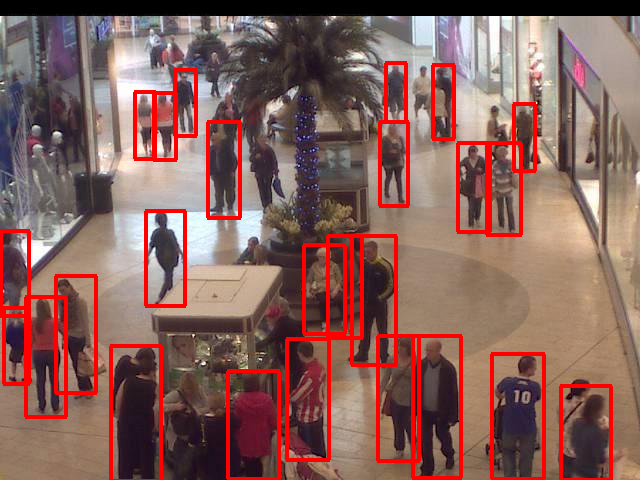

In [ ]:
example_path = data.loc[data['count'] == data['count'].max(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

In [ ]:
sample = data.sample(frac=0.1) #무작위 추출
start = time.perf_counter()
objects = []
#data 는 label.csv
#path는 image

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(count_persons, path, detector, 0.25) for path in sample['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        objects.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

200it [01:46,  1.89it/s]

Finished in 106.17 second(s).


In [ ]:
# Compare predicted values with the ground truth.
sample['prediction'] = objects
sample.head(10)

,id,count,path,prediction
253,254,33,/content/drive/MyDrive/crowd_detection/frames/...,11
1134,1135,33,/content/drive/MyDrive/crowd_detection/frames/...,25
568,569,25,/content/drive/MyDrive/crowd_detection/frames/...,18
681,682,27,/content/drive/MyDrive/crowd_detection/frames/...,17
1754,1755,30,/content/drive/MyDrive/crowd_detection/frames/...,13
1711,1712,40,/content/drive/MyDrive/crowd_detection/frames/...,22
107,108,32,/content/drive/MyDrive/crowd_detection/frames/...,19
472,473,13,/content/drive/MyDrive/crowd_detection/frames/...,22
308,309,32,/content/drive/MyDrive/crowd_detection/frames/...,19
648,649,22,/content/drive/MyDrive/crowd_detection/frames/...,14


MAE = 12.29
MSE = 192.54


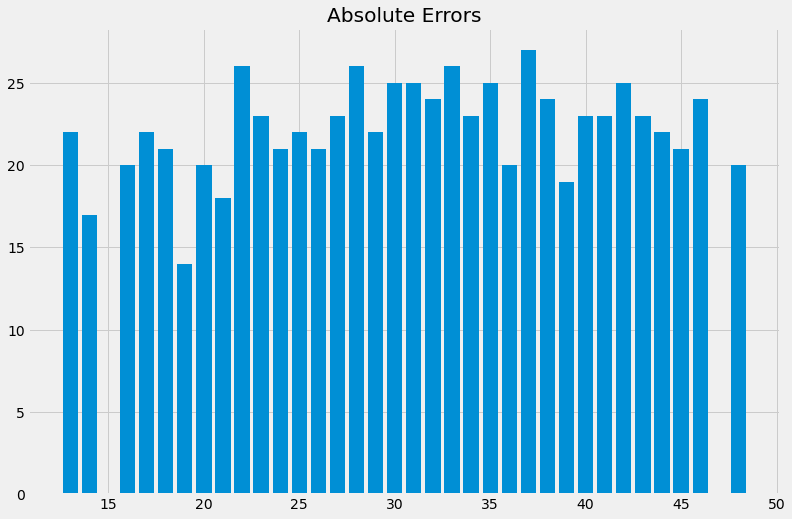

In [ ]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

print(f'MAE = {sample["mae"].mean()}\nMSE = {sample["mse"].mean()}')
plt.bar(sample['count'],sample['prediction'])
plt.title('Absolute Errors')
plt.show()

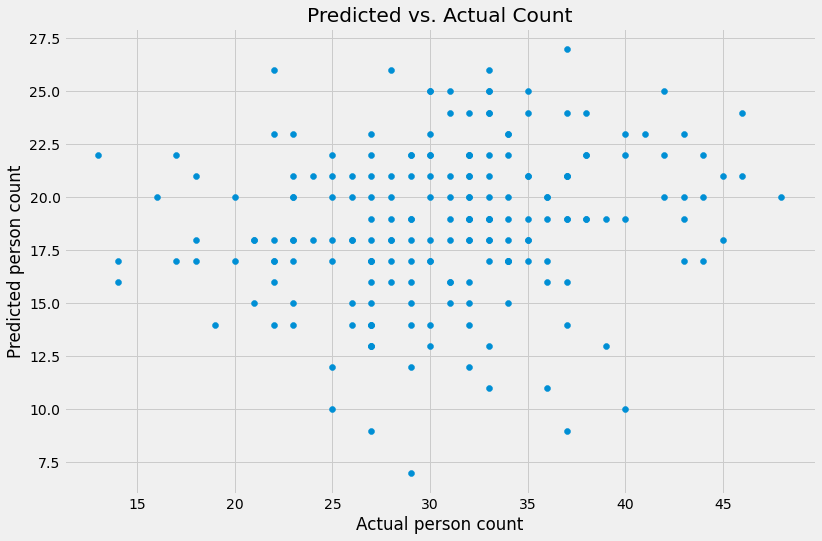

In [ ]:
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel('Actual person count')
plt.ylabel('Predicted person count')
plt.title('Predicted vs. Actual Count')
plt.show()

In [ ]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
miss = sample['mae']

In [ ]:
len(sample)

200

In [ ]:
miss.mean()

12.29

In [ ]:
len(miss)

200